# MNIST Handwritten Digit Classification using CNN
In this lab you'll learn how to create a CNN model for handwritten digit classificaion. The MNIST (Modified National Institute of Standards and Technology) dataset is a collection of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9. 

Tutorial acknolwedgement: How to Develop a CNN for MNIST Handwritten Digit Classification, Deep Learning for Computer Vision by Jason Brownlee 

Your task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9. 

MNIST is one of the most popular dataset that has been used in many introdcutory CNN visual classification tutorials. Below are the examples for different handwritten digits. 


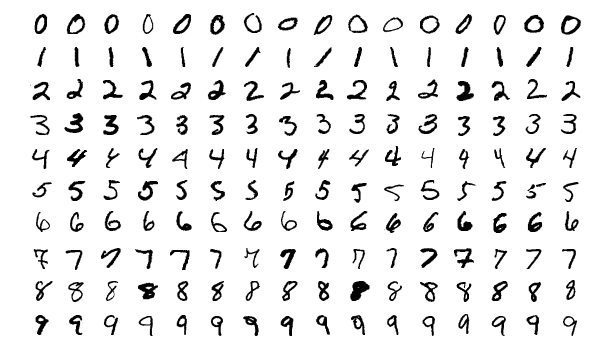
Image source: Wikipedia

# The dataset
It is important to understand the data set to before creating a CNN model. The MNIST dataset has 60,000 label associated with the handwritten digits. We'll use some of them to train the CNN and rest for test. Fortunately Keras include this dataset and therefore, you can just import it (instead of download from http://yann.lecun.com/exdb/mnist/index.html and then read it separately). 

Let's have a sneap peak in the dataset below. 

11493376/11490434 [==============================] - 1s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


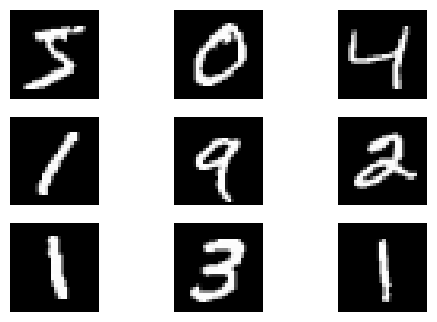

In [1]:
# example of loading the mnist dataset
from keras.datasets import mnist
from matplotlib import pyplot as plt
from matplotlib import rcParams
# Adjust figure sizes
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
    plt.axis('off')
    
# show the figure
plt.show()

# Let's develop a base line model from scratch
There are many well defined CNN models available which may give accurate performance on MNIST dataset. However, you need to know how to build a CNN model, train and test, with k-fold validation. 

In [2]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

from matplotlib import pyplot as plt
from matplotlib import rcParams
# Adjust figure sizes
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Task 1: Load Dataset

We know there are 10 unique classes 0-9 and hence load the labels along with the hand written digits dataset. We'll use the functions to define these.

In [3]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

# Task 2: Prepare Pixel Data
The pixels are gray scale, i.e., the values are between 0-255. As we do not know yet the best way to scale the values for modelling, we'll normalise it between 0-1. 

In [4]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# Task 3: Define the CNN model
As with the lectures, we have two parts of the CNN model:
1. Feature extraction
    1. Convolution - e.g., convolve with a small number (3,3) filters, say 32 filters    
    2. Sub-sampling - e.g., max-pooling
2. Fully connected neural layer classifier (10 classes here)
    1. Nodes, i.e., 10 nodes for for 10 classes
    2.Softmax activation function, e.g., Rectified Linear Unit (ReLU) and the He weight initialization scheme (based on thier popularity)   
3. Some other parameters:
    1. Learning Rate, 0.01    
    2. Momentum 0.9
    3. Loss function, e.g., cross-entropy    
4. Output will be measured in terms of accuracy %.

Note: Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.

In [5]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Task 4: Evaluate Model
So far we have defined the model which needs to be evaluated now. We'll use 5-fold cross validation (20% of the training dataset ~12,000 examples) ensuring to provide a baseline for both repeated evaluation and to not be so large as to require a long running time. 

We choose 10 epochs with a bacth size of 32 examples for the baseline, but you can easily change it to see if there is an performance improvement. we also keep track of the history from each run, as well as the classification accuracy of the fold.

In [6]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

# Task 5: Present Results
Once the model has been evaluated, we need to present the results with two forms, a) the diagnostics of the learning behavior (during training) and b) the estimation of the model performance (accuracy). 

In [7]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(211)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(212)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [8]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

# Task 6: Run the CNN
Create the base line model and evaluate the performances by calling the functions above.

Note:
1. Run time may vary depending on your computer resources, especially when you run the 'evaluate_model()' function.
2. Results may vary in every run due to the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. You may want to run a couple of times to take the average. 

In [14]:
# load dataset
trainX, trainY, testX, testY = load_dataset()      # <--- Uncomment this line

In [15]:
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)         # <--- Uncomment this line

In [16]:
# evaluate model
scores, histories = evaluate_model(trainX, trainY) # <--- Uncomment this line

> 98.667
> 98.750
> 98.442
> 98.867
> 98.758


<ipython-input-7-225bfcd25ea0>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211)
<ipython-input-7-225bfcd25ea0>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(212)


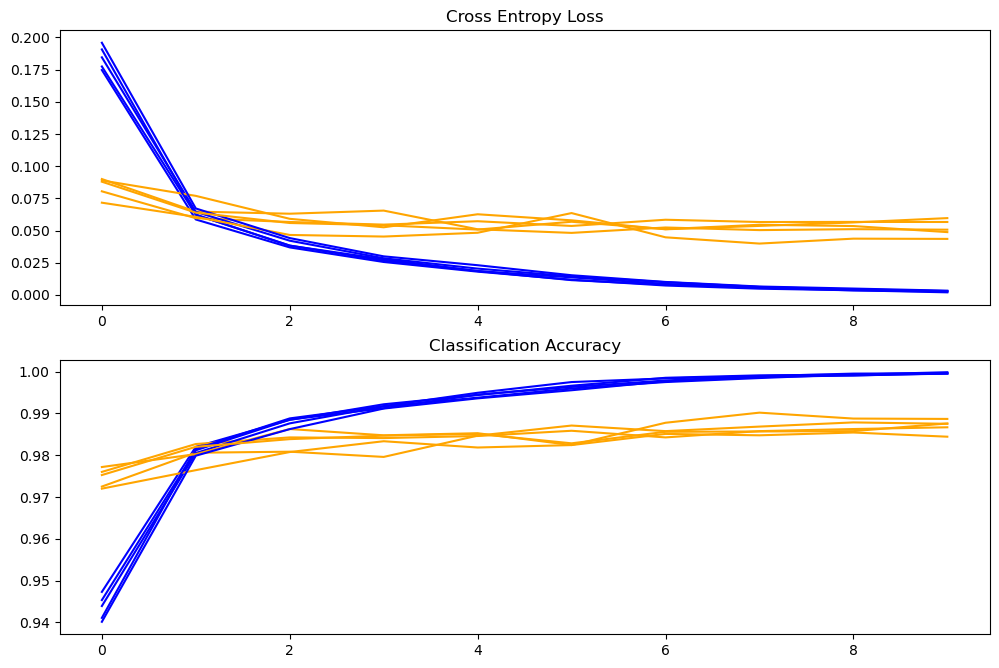

In [17]:
# learning curves
summarize_diagnostics(histories)                   # <--- Uncomment this line

Accuracy: mean=98.697 std=0.142, n=5


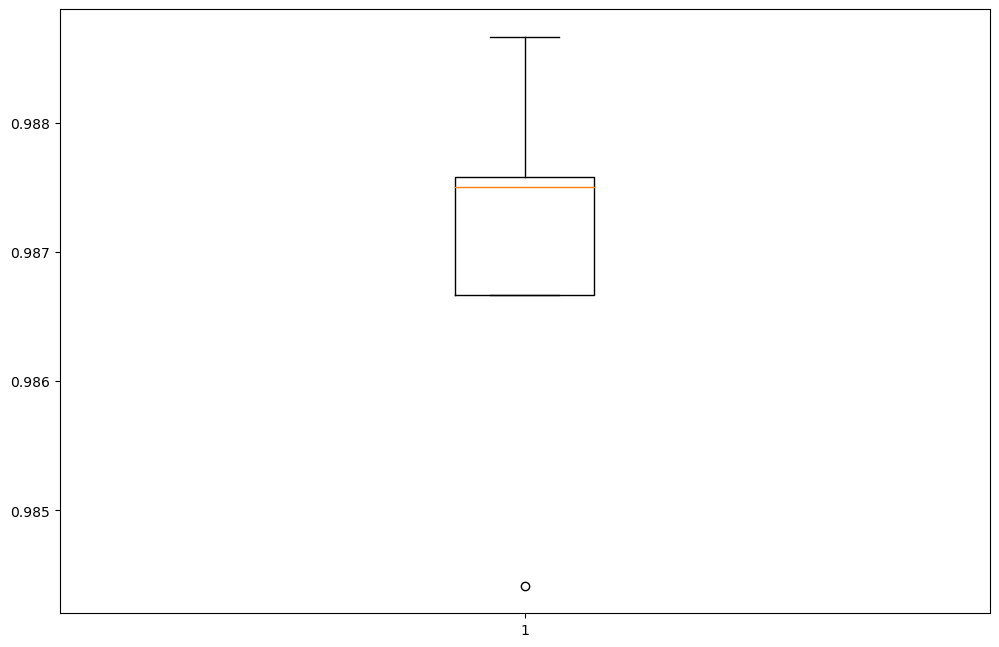

In [18]:
# summarize estimated performance
summarize_performance(scores)                      # <--- Uncomment this line